# DATOS DE PRUEBA

In [1]:
import pandas as pd
import numpy as np

# Leer el archivo CSV
df = pd.read_csv("C:\\Users\\roesc\\Desktop\\hospital-efficiency-dashboard_data\\df_consolidado_final_v2.csv")
df_historico = pd.read_csv("C:\\Users\\roesc\\Desktop\\panel-eficiencia-hospitalaria\\calc-functions\\hospitales.csv")

# pegar columna complejidad de df_historico a df segun hospital_id
df = df.merge(df_historico[['hospital_id', 'complejidad']], on='hospital_id', how='left')

# select unique en 'complejidad'
unique_complexity = df['complejidad'].unique()
# mostrar los valores únicos de la columna 'complejidad'
print("Valores únicos de la columna 'complejidad':", unique_complexity)

# codificar la columna 'complejidad' como numérica
df['complejidad'] = df['complejidad'].map({
    'Baja': 1,
    'Mediana': 2,
    'Alta': 3,
    # null
    np.nan: 0,
})

# pasar a int
df['complejidad'] = df['complejidad'].astype(int)

# renombrar columna complejidad como Complejidad
df.rename(columns={'complejidad': 'Complejidad'}, inplace=True)

# pasar valores '--' a 0 en columnas 'Bienes y servicios' y 'Remuneraciones'
df['Bienes y servicios'] = df['Bienes y servicios'].replace('--', 0)
df['Remuneraciones'] = df['Remuneraciones'].replace('--', 0)

# pasar columnas de tipo string a tipo float
cols_to_float = ['Bienes y servicios', 'Remuneraciones']
for col in cols_to_float:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

# contar missing en las columnas usando pandas
missing_counts = df.isnull().sum()
# mostrar los conteos de valores faltantes
print(missing_counts)

# pasar missing a 0
df.fillna(0, inplace=True)

# contar missing en las columnas usando pandas
missing_counts = df.isnull().sum()
# mostrar los conteos de valores faltantes
print(missing_counts)

# exportar csv y excel
# df.to_csv("./consolidado_final.csv", index=False)
# df.to_excel("./consolidado_final.xlsx", index=False)

df_copy = df.copy()
df_2014 = df_copy[df_copy["Año"] == 2014]
df_2016 = df_copy[df_copy["Año"] == 2016]

# print shapes
print("Shape of original DataFrame:", df.shape)
print("Shape of 2014 DataFrame:", df_2014.shape)
print("Shape of 2016 DataFrame:", df_2016.shape)

Valores únicos de la columna 'complejidad': ['Alta' 'Baja' 'Mediana' nan]
hospital_id                    0
region_id                      0
hospital_name                  0
hospital_alternative_name      6
latitud                        0
longitud                       0
Consultas                      0
GRDxEgreso                   134
Bienes y servicios             0
Remuneraciones                 0
Dias Cama Disponibles          8
Consultas Urgencias            0
Examenes                       0
Quirofanos                     0
Año                            0
Complejidad                    0
dtype: int64
hospital_id                  0
region_id                    0
hospital_name                0
hospital_alternative_name    0
latitud                      0
longitud                     0
Consultas                    0
GRDxEgreso                   0
Bienes y servicios           0
Remuneraciones               0
Dias Cama Disponibles        0
Consultas Urgencias          0
Examenes     

# FUNCIONES

## SFA

In [24]:
import numpy as np
import pandas as pd
from pysfa import SFA

def calculate_sfa_metrics(df: pd.DataFrame,
                          input_cols: list[str],
                          output_col: list[str],
                          te_threshold: float = 0.6,
                          fun: str = SFA.FUN_PROD,
                          method: str = SFA.TE_teJ) -> tuple[pd.DataFrame, dict]:
    """
    Ejecuta SFA sobre df y devuelve:
      - df_out: df con columna 'Eff_SFA'
      - metrics: diccionario con KPI y parámetros clave
    
    Parámetros:
    -----------
    df : DataFrame
      Datos con insumos y output.
    input_cols : lista de str
      Nombres de columnas de insumos.
    output_col : str
      Nombre de la columna de output.
    te_threshold : float
      Umbral para definir 'hospital crítico' (TE < te_threshold).
    fun : str
      Función a usar (SFA.FUN_PROD o FUN_COST).
    method : str
      Método de eficiencia (SFA.TE_teJ, TE_te, TE_teMod).
    
    Retorna:
    --------
    df_out : DataFrame
      df con la nueva columna 'Eff_SFA'.
    metrics : dict
      {
        'ET_promedio': float,      # eficiencia técnica promedio
        'pct_criticos': float,     # % de CRÍTICOS (TE < te_threshold)
        'variable_clave': str,     # insumo con β más alto y p<0.05
        'sigma2': float,           # varianza total del error
        'betas': np.ndarray,       # todos los β incl. intercept y λ
        'p_values': np.ndarray     # todos los p-values
      }
    """
    # solo conservar las filas donde los inputs y outputs son mayores que 0
    df = df[(df[input_cols] > 0).all(axis=1) & (df[output_col] > 0).all(axis=1)]

    x = np.log(df[input_cols]).to_numpy()   # aplicar logaritmo a los inputs
    y = np.log(df[output_col]).to_numpy()   # aplicar logaritmo a los outputs

    sfa = SFA.SFA(y, x, fun=fun, method=method)
    sfa.optimize()
    
    # Extraer eficiencia y añadirla
    te = np.array(sfa.get_technical_efficiency())
    df_out = df.copy()
    df_out['ET SFA'] = te
    
    # Extraer parámetros
    all_betas = np.array(sfa.get_beta())     # [β0, β1..βk, λ]
    all_pvals = np.array(sfa.get_pvalue())
    # sigma2    = sfa.get_sigma2()
    lambda_varianza = sfa.get_lambda()
    
    # ET promedio y % críticos
    et_promedio = float(te.mean())
    pct_crit    = float((te < te_threshold).mean() * 100)
    
    # Determinar variable clave
    k = len(input_cols)
    betas_in = all_betas[1:1+k]
    pvals_in = all_pvals[1:1+k]
    df_coef = pd.DataFrame({
        'input':   input_cols,
        'beta':    betas_in,
        'p_value': pvals_in
    })
    df_sign = df_coef[df_coef.p_value < 0.05].copy()
    if not df_sign.empty:
        df_sign['abs_beta'] = df_sign.beta.abs()
        var_clave = df_sign.sort_values('abs_beta', ascending=False).iloc[0].input
    else:
        var_clave = None

    df_out['percentil'] = pd.qcut(df_out['ET SFA'], 100, labels=False, duplicates='drop') + 1
    
    # Empaquetar métricas
    metrics = {
        'et_promedio':    et_promedio,
        'pct_criticos':   pct_crit,
        'variable_clave': var_clave,
        'varianza':         float(lambda_varianza),
        # 'betas':          all_betas,
        # 'p_values':       all_pvals
    }

    # imprimir summary de sfa
    # print(sfa.summary())
    
    return df_out, metrics

In [2]:
import numpy as np
import pandas as pd
from pysfa import SFA

def calculate_sfa_metrics(df: pd.DataFrame,
                          input_cols: list[str],
                          output_col: list[str],
                          te_threshold: float = 0.6,
                          fun: str = SFA.FUN_PROD,
                          method: str = SFA.TE_teJ) -> tuple[pd.DataFrame, dict]:
    """
    Ejecuta SFA sobre df y devuelve:
      - df_out: df con columna 'Eff_SFA'
      - metrics: diccionario con KPI y parámetros clave
    
    Parámetros:
    -----------
    df : DataFrame
      Datos con insumos y output.
    input_cols : lista de str
      Nombres de columnas de insumos.
    output_col : str
      Nombre de la columna de output.
    te_threshold : float
      Umbral para definir 'hospital crítico' (TE < te_threshold).
    fun : str
      Función a usar (SFA.FUN_PROD o FUN_COST).
    method : str
      Método de eficiencia (SFA.TE_teJ, TE_te, TE_teMod).
    """
    # 1) CREAR MÁSCARA de hospitales válidos (inputs y outputs > 0)
    mask_validos = (df[input_cols] > 0).all(axis=1) & (df[output_col] > 0).all(axis=1)
    
    # 2) SEPARAR hospitales válidos e inválidos
    df_validos = df[mask_validos].copy()
    df_invalidos = df[~mask_validos].copy()
    
    # print(f"Hospitales válidos: {len(df_validos)}")
    # print(f"Hospitales inválidos (ET SFA = 0): {len(df_invalidos)}")
    
    # 3) EJECUTAR SFA solo en hospitales válidos
    if len(df_validos) > 0:
        x = np.log(df_validos[input_cols]).to_numpy()
        y = np.log(df_validos[output_col]).to_numpy()

        sfa = SFA.SFA(y, x, fun=fun, method=method)
        sfa.optimize()
        
        # Extraer eficiencia
        te = np.array(sfa.get_technical_efficiency())
        df_validos['ET SFA'] = te
        
        # Extraer parámetros
        all_betas = np.array(sfa.get_beta())
        all_pvals = np.array(sfa.get_pvalue())
        lambda_varianza = sfa.get_lambda()
        
        # Calcular métricas solo de hospitales válidos
        et_promedio = float(te.mean())
        pct_crit = float((te < te_threshold).mean() * 100)
        
        # Determinar variable clave
        k = len(input_cols)
        betas_in = all_betas[1:1+k]
        pvals_in = all_pvals[1:1+k]
        df_coef = pd.DataFrame({
            'input': input_cols,
            'beta': betas_in,
            'p_value': pvals_in
        })
        df_sign = df_coef[df_coef.p_value < 0.05].copy()
        if not df_sign.empty:
            df_sign['abs_beta'] = df_sign.beta.abs()
            var_clave = df_sign.sort_values('abs_beta', ascending=False).iloc[0].input
        else:
            var_clave = "No determinada"
        
        # Calcular percentiles solo de hospitales válidos
        df_validos['percentil'] = pd.qcut(df_validos['ET SFA'], 100, labels=False, duplicates='drop') + 1
        
    else:
        # No hay hospitales válidos
        et_promedio = 0.0
        pct_crit = 100.0
        var_clave = "No determinada"
        lambda_varianza = 0.0
    
    # 4) ASIGNAR ET SFA = 0 a hospitales inválidos
    if len(df_invalidos) > 0:
        df_invalidos['ET SFA'] = 0.0
        df_invalidos['percentil'] = 0  # Percentil 0 para inválidos
    
    # 5) COMBINAR ambos DataFrames
    df_out = pd.concat([df_validos, df_invalidos], ignore_index=True)
    
    # 6) RECALCULAR métricas incluyendo hospitales con ET SFA = 0
    te_total = df_out['ET SFA'].values
    et_promedio_total = float(te_total.mean())
    pct_crit_total = float((te_total < te_threshold).mean() * 100)
    
    # Empaquetar métricas
    metrics = {
        'et_promedio': et_promedio_total,      # Promedio incluyendo 0s
        'pct_criticos': pct_crit_total,        # % críticos incluyendo 0s
        'variable_clave': var_clave,
        'varianza': float(lambda_varianza)
    }
    
    return df_out, metrics

In [33]:
df_sfa, sfa_metrics = calculate_sfa_metrics(
    df=df_2014,
    input_cols=["Bienes y servicios", "Remuneraciones"],
    output_col=["Quirofanos"],
    te_threshold=0.5
)

# Ejemplo de lectura de métricas:
print(f"Eficiencia promedio: {sfa_metrics['et_promedio']:.2%}")
print(f"% hosp críticos:         {sfa_metrics['pct_criticos']:.2f}%")
print(f"Variable clave:     {sfa_metrics['variable_clave']}")
print(f"Varianza λ:        {sfa_metrics['varianza']:.2f}")

Eficiencia promedio: 8.28%
% hosp críticos:         96.22%
Variable clave:     Remuneraciones
Varianza λ:        1.88


## DEA

In [ ]:
import numpy as np
import pandas as pd
from Pyfrontier.frontier_model import EnvelopDEA

def calculate_dea_metrics(df: pd.DataFrame,
                          input_cols: list[str],
                          output_cols: list[str],
                          orientation: str = "in",
                          rts: str = "CRS",
                          te_threshold: float = 0.6,
                          n_jobs: int = 1
                         ) -> tuple[pd.DataFrame, dict]:
    """
    Ejecuta un DEA y devuelve:
      - df_out: df con columna 'Eff_DEA'
      - metrics: {
          'ET_promedio': float,
          'pct_criticos': float,
          'variable_slack_clave': str,
          'rts': str,
          'orientation': str
        }
    
    Parámetros:
      df           : DataFrame con tus datos
      input_cols   : lista de nombres de columnas de insumos
      output_cols  : lista de nombres de columnas de outputs
      orientation  : 'in' o 'out'
      rts          : 'CRS' o 'VRS'
      te_threshold : umbral para % críticos (score < te_threshold)
    """
    df = df[(df[input_cols] > 0).all(axis=1) & (df[output_cols] > 0).all(axis=1)]

    # 1) Armar arrays
    x = df[input_cols].to_numpy()
    y = df[output_cols].to_numpy()
    
    # 2) Entrenar DEA
    dea_crs = EnvelopDEA(rts, orientation, n_jobs=n_jobs)
    dea_crs.fit(x, y)
    
    # 3) Scores y slacks
    scores_crs = np.array([res.score for res in dea_crs.result])
    # slacks: entrada [n_inputs x_slack_i] en res.x_slack
    slacks_crs = np.stack([res.x_slack for res in dea_crs.result], axis=0)  # shape (n, k)
    
    # 4) DataFrame de salida
    df_out = df.copy()
    df_out["ET DEA"] = scores_crs
    
    # 5) KPI: promedio y críticos
    et_promedio = float(scores_crs.mean())
    pct_crit    = float((scores_crs < te_threshold).mean() * 100)
    
    # 6) Variable slack clave: el input cuyo slack medio es mayor
    mean_slacks = np.nanmean(np.where(slacks_crs==0, np.nan, slacks_crs), axis=0)
    idx_max     = int(np.nanargmax(mean_slacks))
    var_slack_clave = input_cols[idx_max]

    # calcular percentiles para cada hospital
    df_out['percentil'] = pd.qcut(df_out['ET DEA'], 100, labels=False, duplicates='drop') + 1

    
    # 8) Empaquetar métricas
    metrics = {
        "et_promedio":          et_promedio,
        "pct_criticos":         pct_crit,
        "top_slack_promedio": var_slack_clave,
        # "orientation":          orientation,
        # "rts":                  rts
    }
    return df_out, metrics


In [ ]:
import numpy as np
import pandas as pd
from Pyfrontier.frontier_model import EnvelopDEA

def calculate_dea_metrics(df: pd.DataFrame,
                          input_cols: list[str],
                          output_cols: list[str],
                          orientation: str = "in",
                          rts: str = "CRS",
                          te_threshold: float = 0.6,
                          n_jobs: int = 1
                         ) -> tuple[pd.DataFrame, dict]:
    """
    Ejecuta un DEA y devuelve:
      - df_out: df con columna 'ET DEA' (0 para hospitales que no cumplen filtros)
      - metrics: diccionario con KPI y parámetros clave
    
    Parámetros:
      df           : DataFrame con tus datos
      input_cols   : lista de nombres de columnas de insumos
      output_cols  : lista de nombres de columnas de outputs
      orientation  : 'in' o 'out'
      rts          : 'CRS' o 'VRS'
      te_threshold : umbral para % críticos (score < te_threshold)
    """
    
    # 1) CREAR MÁSCARA de hospitales válidos (inputs y outputs > 0)
    mask_validos = (df[input_cols] > 0).all(axis=1) & (df[output_cols] > 0).all(axis=1)
    
    # 2) SEPARAR hospitales válidos e inválidos
    df_validos = df[mask_validos].copy()
    df_invalidos = df[~mask_validos].copy()
    
    # print(f"Hospitales válidos: {len(df_validos)}")
    # print(f"Hospitales inválidos (ET DEA = 0): {len(df_invalidos)}")
    
    # 3) EJECUTAR DEA solo en hospitales válidos
    if len(df_validos) > 0:
        # Armar arrays
        x = df_validos[input_cols].to_numpy()
        y = df_validos[output_cols].to_numpy()
        
        # Entrenar DEA
        dea_crs = EnvelopDEA(rts, orientation, n_jobs=n_jobs)
        dea_crs.fit(x, y)
        
        # Scores y slacks
        scores_crs = np.array([res.score for res in dea_crs.result])
        slacks_crs = np.stack([res.x_slack for res in dea_crs.result], axis=0)  # shape (n, k)
        
        # Asignar scores a hospitales válidos
        df_validos["ET DEA"] = scores_crs
        
        # KPI: promedio y críticos (solo de hospitales válidos)
        et_promedio = float(scores_crs.mean())
        pct_crit = float((scores_crs < te_threshold).mean() * 100)
        
        # Variable slack clave: el input cuyo slack medio es mayor
        mean_slacks = np.nanmean(np.where(slacks_crs==0, np.nan, slacks_crs), axis=0)
        if not np.isnan(mean_slacks).all():  # Verificar que hay slacks válidos
            idx_max = int(np.nanargmax(mean_slacks))
            var_slack_clave = input_cols[idx_max]
        else:
            var_slack_clave = "No determinado"
        
        # Calcular percentiles solo de hospitales válidos
        df_validos['percentil'] = pd.qcut(df_validos['ET DEA'], 100, labels=False, duplicates='drop') + 1
        
    else:
        # No hay hospitales válidos
        et_promedio = 0.0
        pct_crit = 100.0
        var_slack_clave = "No determinado"
    
    # 4) ASIGNAR ET DEA = 0 a hospitales inválidos
    if len(df_invalidos) > 0:
        df_invalidos['ET DEA'] = 0.0
        df_invalidos['percentil'] = 0  # Percentil 0 para inválidos
    
    # 5) COMBINAR ambos DataFrames
    df_out = pd.concat([df_validos, df_invalidos], ignore_index=True)
    
    # 6) RECALCULAR métricas incluyendo hospitales con ET DEA = 0
    te_total = df_out['ET DEA'].values
    et_promedio_total = float(te_total.mean())
    pct_crit_total = float((te_total < te_threshold).mean() * 100)
    
    # 7) Empaquetar métricas
    metrics = {
        "et_promedio": et_promedio_total,           # Promedio incluyendo 0s
        "pct_criticos": pct_crit_total,             # % críticos incluyendo 0s
        "top_slack_promedio": var_slack_clave,
        # "hospitales_validos": len(df_validos),
        # "hospitales_invalidos": len(df_invalidos)
    }
    
    return df_out, metrics

In [39]:
df_dea, dea_metrics = calculate_dea_metrics(
    df=df_2014,
    input_cols=["Bienes y servicios", "Remuneraciones", "Dias Cama Disponibles"],
    output_cols=["Consultas"],
    orientation="in",
    rts="CRS",
    te_threshold=0.6,
    n_jobs=2
)

print(f"ET Promedio:      {dea_metrics['et_promedio']:.2%}")
print(f"% Hosp. críticos:  {dea_metrics['pct_criticos']:.2f}%")
print(f"Slack promedio mas alto: {dea_metrics['top_slack_promedio']}")

ET Promedio:      18.74%
% Hosp. críticos:  93.51%
Slack promedio mas alto: Remuneraciones


## DEA-M

In [ ]:
def calculate_dea_malmquist_simple(df_t, df_t1,
                                   input_cols, output_cols,
                                   rts="CRS", orientation="in",
                                   n_jobs: int = 1):
    """
    Índice de Malmquist simplificado = solo cambio de eficiencia
    """
    print(f"Shapes iniciales - df_t: {df_t.shape}, df_t1: {df_t1.shape}")
    
    # 1) PRIMERO: Filtrar valores > 0 en cada período por separado
    df_t_clean = df_t[(df_t[input_cols] > 0).all(axis=1) & (df_t[output_cols] > 0).all(axis=1)].copy()
    df_t1_clean = df_t1[(df_t1[input_cols] > 0).all(axis=1) & (df_t1[output_cols] > 0).all(axis=1)].copy()
    
    print(f"Después de filtrar > 0 - df_t_clean: {df_t_clean.shape}, df_t1_clean: {df_t1_clean.shape}")
    
    # 2) SEGUNDO: Intersectar hospitales comunes entre los datos ya filtrados
    common_ids = set(df_t_clean['hospital_id']).intersection(set(df_t1_clean['hospital_id']))
    
    print(f"Hospitales comunes después del filtrado: {len(common_ids)}")
    
    if len(common_ids) == 0:
        raise ValueError("No hay hospitales comunes después del filtrado de valores > 0")
    
    # 3) Aplicar la intersección
    df_t_final = df_t_clean[df_t_clean['hospital_id'].isin(common_ids)].copy()
    df_t1_final = df_t1_clean[df_t1_clean['hospital_id'].isin(common_ids)].copy()
    
    # 4) Ordenar por hospital_id para garantizar mismo orden
    df_t_final = df_t_final.sort_values('hospital_id').reset_index(drop=True)
    df_t1_final = df_t1_final.sort_values('hospital_id').reset_index(drop=True)
    
    print(f"Shapes finales - df_t_final: {df_t_final.shape}, df_t1_final: {df_t1_final.shape}")
    print(f"¿Mismo shape? {df_t_final.shape == df_t1_final.shape}")
    
    # 5) Verificar que los hospital_id coinciden
    if not df_t_final['hospital_id'].equals(df_t1_final['hospital_id']):
        print("⚠️  ADVERTENCIA: Los hospital_id no están en el mismo orden")
        # Reordenar df_t1_final para que coincida con df_t_final
        df_t1_final = df_t1_final.set_index('hospital_id').loc[df_t_final['hospital_id']].reset_index()
    
    # 6) Armar arrays
    x_t = df_t_final[input_cols].to_numpy()
    y_t = df_t_final[output_cols].to_numpy()
    x_t1 = df_t1_final[input_cols].to_numpy()
    y_t1 = df_t1_final[output_cols].to_numpy()
    
    # 7) Entrenar DEA
    dea_t = EnvelopDEA(rts, orientation, n_jobs=n_jobs)
    dea_t.fit(x_t, y_t)
    
    dea_t1 = EnvelopDEA(rts, orientation, n_jobs=n_jobs)
    dea_t1.fit(x_t1, y_t1)
    
    # 8) Extraer scores
    scores_t = np.array([res.score for res in dea_t.result])
    scores_t1 = np.array([res.score for res in dea_t1.result])
    
    print(f"Scores obtenidos - t: {len(scores_t)}, t1: {len(scores_t1)}")

    # guardar scores
    df_t_final['ET DEA t'] = scores_t
    df_t1_final['ET DEA t1'] = scores_t1

    effch = scores_t1 / scores_t

    # 8) Armar DataFrame de salida
    df_out = pd.DataFrame({
        'hospital_id': df_t_final['hospital_id'],
        'ET_DEA_t':   scores_t,
        'ET_DEA_t1':  scores_t1,
        'EFFCH':      effch
    }).set_index('hospital_id')

    # 9) Resumen
    summary = {
        'EFFCH_mean': float(effch.mean()),
        'n_hospitals': len(effch)
    }

    return df_out, summary

    # salida = pd.DataFrame({
    #     'hospital_id': df_t_final['hospital_id'],
    #     'ET DEA t': df_t_final['ET DEA t'],
    #     'ET DEA t1': df_t1_final['ET DEA t1']
    # })
    
    # return salida

In [ ]:
import numpy as np
import pandas as pd
from Pyfrontier.frontier_model import EnvelopDEA

def calculate_dea_malmquist(df_t, df_t1,
                            input_cols, output_cols,
                            rts="CRS", orientation="in",
                            n_jobs: int = 1,
                            use_cross: bool = True):
    """
    Índice de Malmquist completo:
      • EFFCH = cambio de eficiencia (catch-up)
      • TECH  = cambio tecnológico (frontier-shift), via cross-efficiencies
      • Malmquist = EFFCH * TECH

    Si use_cross=False, se fuerza TECH=1 para ahorrar tiempo de cómputo.
    """
    # --- 1) Filtrar y alinear IDs comunes ---------------------
    # Filtrar valores positivos en cada periodo
    df_t_clean  = df_t[(df_t[input_cols] > 0).all(axis=1)  &
                       (df_t[output_cols] > 0).all(axis=1)].copy()
    df_t1_clean = df_t1[(df_t1[input_cols] > 0).all(axis=1) &
                        (df_t1[output_cols] > 0).all(axis=1)].copy()

    # Intersectar hospital_id
    common = set(df_t_clean['hospital_id']) & set(df_t1_clean['hospital_id'])
    if not common:
        raise ValueError("No hay hospitales comunes tras filtrar >0")

    # Subconjunto y ordenar
    df1 = (df_t_clean [df_t_clean ['hospital_id'].isin(common)]
           .sort_values('hospital_id').reset_index(drop=True))
    df2 = (df_t1_clean[df_t1_clean['hospital_id'].isin(common)]
           .sort_values('hospital_id').reset_index(drop=True))

    # Asegurar mismo orden
    if not df1['hospital_id'].equals(df2['hospital_id']):
        df2 = (df2.set_index('hospital_id')
               .loc[df1['hospital_id']]
               .reset_index())

    # --- 2) Construir matrices X, Y ---------------------------
    X1, Y1 = df1[input_cols].to_numpy(), df1[output_cols].to_numpy()
    X2, Y2 = df2[input_cols].to_numpy(), df2[output_cols].to_numpy()

    # --- 3) Calcular scores propios --------------------------
    dea1 = EnvelopDEA(rts, orientation, n_jobs=n_jobs); dea1.fit(X1, Y1)
    dea2 = EnvelopDEA(rts, orientation, n_jobs=n_jobs); dea2.fit(X2, Y2)
    eff1 = np.array([r.score for r in dea1.result])
    eff2 = np.array([r.score for r in dea2.result])

    # --- 4) Cross-eficiencias (TECH) -------------------------
    if use_cross:
        tech1_on_2 = []
        for x2, y2 in zip(X2, Y2):
            dea_cross = EnvelopDEA(rts, orientation, n_jobs=n_jobs)
            dea_cross.fit(np.vstack([X1, x2]), np.vstack([Y1, y2]))
            tech1_on_2.append(dea_cross.result[-1].score)
        tech1_on_2 = np.array(tech1_on_2)

        tech2_on_1 = []
        for x1, y1 in zip(X1, Y1):
            dea_cross = EnvelopDEA(rts, orientation, n_jobs=n_jobs)
            dea_cross.fit(np.vstack([X2, x1]), np.vstack([Y2, y1]))
            tech2_on_1.append(dea_cross.result[-1].score)
        tech2_on_1 = np.array(tech2_on_1)

        TECH = np.sqrt((tech1_on_2 / eff1) * (eff2 / tech2_on_1))
    else:
        # omitimos cross, TECH = 1
        TECH = np.ones_like(eff1)

    # --- 5) Calcular EFFCH y Malmquist ------------------------
    EFFCH     = eff2 / eff1
    MALMQUIST = EFFCH * TECH

    # --- 6) Montar DataFrame de salida -----------------------
    df_out = pd.DataFrame({
        'EFF_t':        eff1,
        'EFF_t1':       eff2,
        'EFFCH':        EFFCH,
        'TECH':         TECH,
        'Malmquist':    MALMQUIST
    }, index=df1['hospital_id'])

    # --- 7) Resumen de medias -------------------------------
    summary = {
        'EFFCH_mean':      float(EFFCH.mean()),
        'TECH_mean':       float(TECH.mean()),
        'Malmquist_mean':  float(MALMQUIST.mean()),
        'n_hospitals':     len(EFFCH)
    }

    return df_out, summary


In [ ]:
# Periodos t=2014 y t1=2016
df_malm, malm_meta = calculate_dea_malmquist(
    df_2014, df_2016,
    input_cols   = ["Bienes y servicios", "Remuneraciones"],
    output_cols  = ["Consultas"],
    rts          = "CRS",
    orientation  = "in",
    n_jobs       = 2,
    use_cross    = True    # o False si quieres solo EFFCH
)

print("Malmquist (total) promedio:", malm_meta['Malmquist_mean'])
print("Cambio eficiencia (EFFCH):", malm_meta['EFFCH_mean'])
print("Cambio tecnológico (TECH):", malm_meta['TECH_mean'])


In [ ]:
df_malm, malm_meta = calculate_dea_malmquist_simple(
    df_2014, df_2016,
    input_cols  = ["Bienes y servicios", "Remuneraciones"],
    output_cols = ["Consultas"],
    rts="CRS", orientation="in",
    n_jobs=4
)

# print("Cambio de eficiencia promedio (EFFCH):",
#       f"{malm_simp_meta['EFFCH_mean']:.3f}")
# df_malm_simp.head()


# df_malm_simp, malm_simp_meta = calculate_dea_malmquist_simple(
#     df_2014, df_2016,
#     input_cols  = ["Bienes y servicios", "Remuneraciones"],
#     output_cols = ["Consultas"],
#     rts="CRS", orientation="in",
#     n_jobs=4
# )

# print("Cambio de eficiencia promedio (EFFCH):",
#       f"{malm_simp_meta['EFFCH_mean']:.3f}")
# df_malm_simp.head()


## PCA

In [3]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from typing import List, Tuple, Dict

def run_pca(df: pd.DataFrame,
            feature_cols: List[str],
            n_components: int | None = None,
            scale: bool = True
           ) -> Tuple[pd.DataFrame, Dict]:
    """
    Ejecuta PCA sobre las columnas `feature_cols` y devuelve:
      • df_pca  : DataFrame con columnas PC1, PC2, …, PCk
      • metrics : dict con varianza explicada y matriz de cargas
    
    Parámetros
    ----------
    df           : DataFrame original
    feature_cols : columnas a incluir en el PCA (solo numéricas)
    n_components : nº de componentes (None ⇒ tantas como variables)
    scale        : estandarizar variables a media 0 y σ 1 antes de PCA
    
    Ejemplo
    -------
    df_pca, meta = run_pca(df, ["slack_bs", "slack_rem", "slack_cama"], 2)
    """
    X = df[feature_cols].to_numpy(dtype=float)
    
    # Escalado opcional
    if scale:
        X = StandardScaler().fit_transform(X)
    
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(X)
    
    pc_cols = [f"PC{i+1}" for i in range(pcs.shape[1])]
    df_pca  = pd.DataFrame(pcs, index=df.index, columns=pc_cols)
    
    metrics = {
        "explained_variance_ratio": pca.explained_variance_ratio_.tolist(),
        "components": pd.DataFrame(pca.components_,
                                   index=pc_cols,
                                   columns=feature_cols)
    }
    return df_pca, metrics

Varianza explicada: [0.8792078363479907, 0.08028637668523515]

Matriz de cargas:
     Bienes y servicios  Remuneraciones  Consultas  GRDxEgreso
PC1            0.506020        0.505304   0.491301    0.497227
PC2           -0.492191       -0.493758   0.552828    0.456435

Contribuciones de variables a los PCs:
     Bienes y servicios  Remuneraciones  Consultas  GRDxEgreso
PC1            0.256056        0.255333   0.241376    0.247235
PC2            0.242252        0.243797   0.305618    0.208333


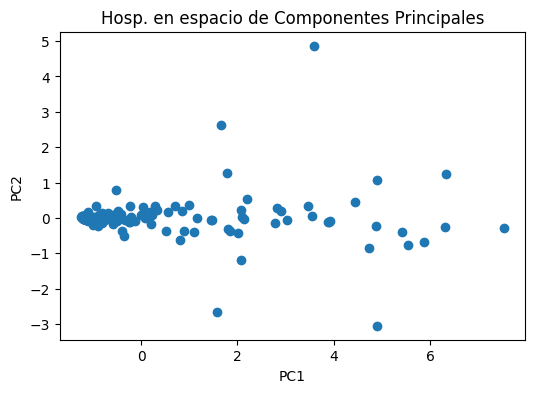

In [4]:
import matplotlib.pyplot as plt

# 1) Selecciona las columnas que quieres analizar
input_cols  = ["Bienes y servicios", "Remuneraciones"]
output_cols = ["Consultas", "GRDxEgreso"]

# unir columnas en una sola lista
cols_pca = input_cols + output_cols

# 2) Ejecuta PCA (2 componentes para plot)
df_pca, pca_meta = run_pca(df_2014, cols_pca, n_components=2)

# 3) KPI rápidos
print("Varianza explicada:", pca_meta["explained_variance_ratio"])
print("\nMatriz de cargas:")
print(pca_meta["components"])

loadings = pca_meta["components"]   # DataFrame PC×vars
squared = loadings**2           # coef²
contribs = squared.div(squared.sum(axis=1), axis=0)

# 4) Mostrar contribuciones de cada variable a los PCs
print("\nContribuciones de variables a los PCs:")
print(contribs)

# 4) Ejemplo de visualización 2-D
plt.figure(figsize=(6,4))
plt.scatter(df_pca["PC1"], df_pca["PC2"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Hosp. en espacio de Componentes Principales")
plt.show()


## CLUSTERIZACIÓN

In [5]:
from typing import List, Tuple, Dict
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ------- usa la función run_pca que ya tienes --------
def pca_kmeans(df: pd.DataFrame,
               feature_cols: List[str],
               n_components: int = 2,
               k: int | None = None,
               k_max: int = 10,
               scale: bool = True,
               random_state: int = 42
              ) -> Tuple[pd.DataFrame, Dict]:
    """
    1) Ejecuta PCA con run_pca
    2) Aplica K-means (elige k óptimo con silhouette si k=None)
    3) Devuelve df con PCs y 'cluster', y un diccionario de metadatos
    """
    # ---- PCA --------------------------------------------------
    df_pca, pca_meta = run_pca(df, feature_cols,
                               n_components=n_components,
                               scale=scale)
    pc_cols = df_pca.columns.tolist()

    # ---- elegir k si no viene fijo ---------------------------
    if k is None:
        best_k, best_score = 2, -1
        for kk in range(2, k_max + 1):
            km = KMeans(n_clusters=kk, n_init="auto", random_state=random_state)
            labels = km.fit_predict(df_pca[pc_cols])
            score = silhouette_score(df_pca[pc_cols], labels)
            if score > best_score:
                best_k, best_score = kk, score
        k = best_k
        silhouette_best = best_score
    else:
        silhouette_best = None

    # ---- K-means definitivo -----------------------------------
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=random_state)
    cluster_labels = kmeans.fit_predict(df_pca[pc_cols])

    # calcular silhouette si no se calculó antes
    if silhouette_best is None:
        silhouette_best = silhouette_score(df_pca[pc_cols], cluster_labels)

    # ---- ensamblar DataFrame de salida ------------------------
    df_out = df.copy()
    df_out = pd.concat([df_out, df_pca], axis=1)
    df_out["cluster"] = cluster_labels

    # ---- empaquetar metadatos ---------------------------------
    meta = {
        "explained_variance_ratio": pca_meta["explained_variance_ratio"],
        "components": pca_meta["components"],
        "k": k,
        "silhouette": silhouette_best,
        "cluster_centers": pd.DataFrame(kmeans.cluster_centers_,
                                        columns=pc_cols)
    }
    return df_out, meta

k elegido: 2
Varianza explicada: [0.8792078363479907, 0.08028637668523518, 0.030592982630942164]

Matriz de cargas:
     Bienes y servicios  Remuneraciones  Consultas  GRDxEgreso
PC1            0.506020        0.505304   0.491301    0.497227
PC2           -0.492191       -0.493758   0.552828    0.456435
PC3            0.147653       -0.216694  -0.650558    0.712753

Silhouette score: 0.757

Resumen de clusters:
   cluster  N_Hospitales  ET_Media  PC1_media  PC2_media
0        0           151      0.25      -0.79      -0.01
1        1            34      0.25       3.50       0.03


c:\Users\roesc\miniconda3\envs\python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


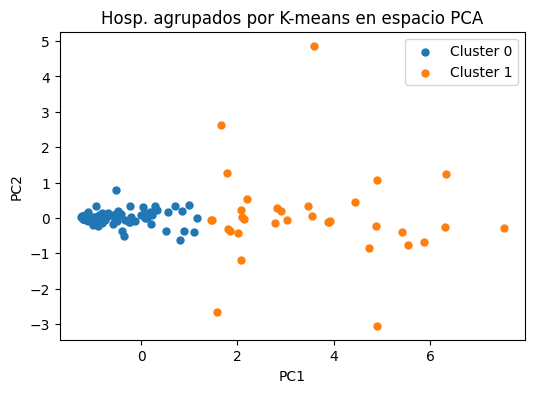

In [9]:
# columnas para el PCA
feature_cols = ["Bienes y servicios", "Remuneraciones","Consultas",
                "GRDxEgreso"]

# ejecutar sfa con funcion creada
df_sfa, sfa_metrics = calculate_sfa_metrics(
    df=df_2014,
    input_cols=["Bienes y servicios", "Remuneraciones"],
    output_col=["Consultas","GRDxEgreso"],
    te_threshold=0.5
)

df_cluster, info = pca_kmeans(df_sfa,
                              feature_cols=feature_cols,
                              n_components=3,   # sólo PC1 y PC2
                              k=2,           # deja que la función elija
                              k_max=8)

print("k elegido:", info["k"])
print("Varianza explicada:", info["explained_variance_ratio"])
print("\nMatriz de cargas:")
print(info["components"])

# 1) Agrupa y agrega
summary = df_cluster.groupby("cluster").agg(
    N_Hospitales = ("cluster", "size"),
    ET_Media     = ("ET SFA", "mean"),
    PC1_media    = ("PC1", "mean"),
    PC2_media    = ("PC2", "mean"),
).reset_index()

# 2) Formatea un poquito (opcional)
summary["ET_Media"]  = summary["ET_Media"].round(2)
summary["PC1_media"] = summary["PC1_media"].round(2)
summary["PC2_media"] = summary["PC2_media"].round(2)

# mostrar silhouette si se calculó
if info["silhouette"] is not None:
    print(f"\nSilhouette score: {info['silhouette']:.3f}")

# 3) Muestra
print("\nResumen de clusters:")
print(summary)

# Visualizar
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
for cl in range(info["k"]):
    mask = df_cluster["cluster"] == cl
    plt.scatter(df_cluster.loc[mask, "PC1"],
                df_cluster.loc[mask, "PC2"],
                s=25, label=f"Cluster {cl}")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.title("Hosp. agrupados por K-means en espacio PCA")
plt.show()

## ANÁLISIS DE DETERMINANTES

In [53]:
# deter_analysis.py
%pip install statsmodels
import pandas as pd
import numpy as np
import statsmodels.api as sm
from typing import List, Tuple, Dict

def determinant_analysis(df: pd.DataFrame,
                         dependent: str,
                         independents: List[str],
                         top_n: int = 5,
                         add_constant: bool = True
                        ) -> Tuple[pd.DataFrame, Dict]:
    """
    Ajusta un modelo OLS  y entrega la tabla de coeficientes + métricas resumidas.
    
    Parámetros
    ----------
    df          : DataFrame con los datos (sin nulos en cols usadas)
    dependent   : nombre de la columna dependiente (Y)
    independents: lista de columnas explicativas (X)
    top_n       : nº de determinantes "clave" a destacar
    add_constant: añade intercepto si True
    
    Devuelve
    --------
    coef_table : DataFrame con coef, std_err, t, p
    meta       : dict  {
                         'r2'           : float,
                         'r2_adj'       : float,
                         'top_vars'     : list[str]
                       }
    """
    # 0) Filtrar filas completas
    df_clean = df.dropna(subset=[dependent] + independents).copy()

    # 1) Matrices
    y = df_clean[dependent].astype(float).to_numpy()
    X = df_clean[independents].astype(float)
    if add_constant:
        X = sm.add_constant(X)
    
    # 2) Ajustar modelo
    model = sm.OLS(y, X).fit()
    
    # 3) Tabla de coeficientes
    coef_table = model.summary2().tables[1]                 # coef, std err, t, P>|t|
    coef_table.index.name = "variable"
    coef_table.reset_index(inplace=True)
    
    # 4) Variables “clave”  (|coef| grande & p<0.05)
    sig = coef_table[coef_table["P>|t|"] < 0.05].copy()
    sig["abs_coef"] = sig["Coef."].abs()
    sig_sorted = sig.sort_values("abs_coef", ascending=False)
    top_vars = sig_sorted["variable"].head(top_n).tolist()
    
    # 5) Métricas de resumen
    meta = {
        "r2":      model.rsquared,
        "r2_adj":  model.rsquared_adj,
        "top_vars": top_vars
    }
    return coef_table, meta


Note: you may need to restart the kernel to use updated packages.


In [58]:
import numpy as np
import statsmodels.api as sm

def regression_analysis_logit(df, dependent, independents, 
                             add_constant=True, top_n=3):
    """
    Análisis de regresión con transformación logit para variables [0,1]
    Equivalente funcional a Tobit para eficiencia
    """
    
    # 0) Filtrar filas completas
    df_clean = df.dropna(subset=[dependent] + independents).copy()

    # 1) Transformación logit para variable dependiente
    y_raw = df_clean[dependent].astype(float).to_numpy()
    
    # Ajustar valores extremos (evitar ln(0) o ln(∞))
    epsilon = 1e-6
    y_raw = np.clip(y_raw, epsilon, 1-epsilon)
    
    # Transformación: logit(p) = ln(p/(1-p))
    y_logit = np.log(y_raw / (1 - y_raw))
    
    # 2) Variables independientes
    X = df_clean[independents].astype(float)
    if add_constant:
        X = sm.add_constant(X)
    
    # 3) Ajustar modelo OLS en escala logit
    model = sm.OLS(y_logit, X).fit()
    
    # 4) Tabla de coeficientes
    coef_table = model.summary2().tables[1]
    coef_table.index.name = "variable"
    coef_table.reset_index(inplace=True)
    
    # 5) Variables "clave"
    sig = coef_table[coef_table["P>|t|"] < 0.05].copy()
    sig["abs_coef"] = sig["Coef."].abs()
    sig_sorted = sig.sort_values("abs_coef", ascending=False)
    top_vars = sig_sorted["variable"].head(top_n).tolist()
    
    # 6) Métricas de resumen
    meta = {
        "r2": model.rsquared,
        "r2_adj": model.rsquared_adj,
        "top_vars": top_vars,
        "model_type": "OLS_Logit",
        "transformation": "logit"
    }
    
    return coef_table, meta

In [59]:
# CALCULAR SFA
df_sfa, sfa_metrics = calculate_sfa_metrics(
    df=df_2014,
    input_cols=["Bienes y servicios", "Remuneraciones"],
    output_col=["Quirofanos"],
    te_threshold=0.5
)

coef_tbl, info = determinant_analysis(
    df           = df_sfa,
    dependent    = "ET SFA",              # o el KPI que quieras explicar
    independents = ['Complejidad',"Consultas", "Examenes"],
    top_n        = 2
)

# Mostrar tabla de coeficientes
print("\nTabla de coeficientes:")
print(coef_tbl)
# Mostrar métricas de resumen
print("\nMétricas de resumen:")
print(f"R²: {info['r2']:.3f}, R² ajustado: {info['r2_adj']:.3f}")
print("Variables clave:", info['top_vars'])



Tabla de coeficientes:
      variable         Coef.      Std.Err.         t     P>|t|        [0.025  \
0        const -6.715064e-02  2.312511e-02 -2.903798  0.004146 -1.127801e-01   
1  Complejidad  6.887253e-02  1.361668e-02  5.057954  0.000001  4.200469e-02   
2    Consultas  7.094393e-07  2.739593e-07  2.589579  0.010391  1.688745e-07   
3     Examenes -2.380363e-08  3.392938e-08 -0.701564  0.483852 -9.075163e-08   

         0.975]  
0 -2.152117e-02  
1  9.574038e-02  
2  1.250004e-06  
3  4.314437e-08  

Métricas de resumen:
R²: 0.375, R² ajustado: 0.365
Variables clave: ['Complejidad', 'const']


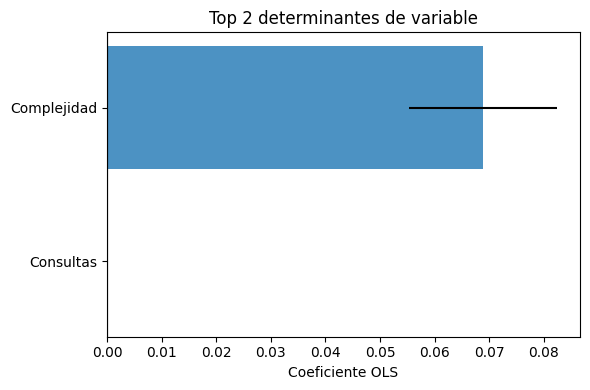

In [60]:
import matplotlib.pyplot as plt

def plot_determinants(coef_tbl: pd.DataFrame,
                      top_n: int = 5,
                      figsize: Tuple[int,int] = (6,4)):
    """
    Dibuja un barplot de los top_n coeficientes (en valor absoluto),
    con barras de error según el std err, y marca en rojo los no-signif.
    """
    # Filtrar solo variables X (descartar const si la hay)
    tbl = coef_tbl[coef_tbl['variable'] != 'const'].copy()
    
    # Tomar las top_n por |coef|
    tbl['abs_coef'] = tbl['Coef.'].abs()
    tbl = tbl.sort_values('abs_coef', ascending=False).head(top_n)
    
    # Preparar datos
    vars_ = tbl['variable']
    coefs = tbl['Coef.']
    errs  = tbl['Std.Err.']
    pvals = tbl['P>|t|']
    
    # Colores según significancia
    colors = ['C0' if p < 0.05 else 'C3' for p in pvals]
    
    # Plot
    plt.figure(figsize=figsize)
    plt.barh(vars_, coefs, xerr=errs, color=colors, alpha=0.8)
    plt.axvline(0, color='k', linewidth=0.8)
    plt.gca().invert_yaxis()  # para que el mayor coef aparezca arriba
    plt.xlabel('Coeficiente OLS')
    plt.title(f'Top {top_n} determinantes de {coef_tbl.variable.name}')
    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
plot_determinants(coef_tbl, top_n=2)